#Adversarial Attacks on MNIST Data

  * **Members**:  *Awantee (s8awdesh@stud.uni-saarland.de), Daniel (s8daberr@stud.uni-saarland.de), Shubham (s8shagar@stud.uni-saarland.de)*

  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we implement an evasion attack and then try to defend our model.   

 

In [0]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [0]:
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

import tensorflow as tf
import torchvision
import random
import foolbox

In [0]:
compute_mode = 'gpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

Hyperparameters defined for our Neural Network used throughout this exercise:

In [0]:
def identity_func(foo):
    return foo

batch_size_train = 64
batch_size_test = 1
n_epochs = 5

learning_rate = 0.01
momentum = 0.9
dropout = 0.5

random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

#### Helper Methods

In [0]:
# (1)load data

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../MLCS/', train = True, download = False,
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])),
    batch_size = batch_size_train, shuffle = True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../MLCS/', train = False, download = False,
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])),
    batch_size = batch_size_test, shuffle = False)

train_data = enumerate(train_loader)
batch_idx, (x_trainval, y_trainval) = next(train_data)
test_data = enumerate(test_loader)
batch_idx, (x_test, y_test) = next(test_data)

print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))


DEBUG_FRAC = 1.0
x_trainval = x_trainval[: int(len(x_trainval) * DEBUG_FRAC)]
y_trainval = y_trainval[: int(len(y_trainval) * DEBUG_FRAC)]

test_set = 'test'

if test_set == 'test':
    train_idxs, val_idxs = range(0,int(0.75*len(x_trainval))), range(int(0.75*len(x_trainval)),len(x_trainval))
    x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
else:
    x_train, y_train = x_trainval, y_trainval
    x_eval, y_eval = x_test, y_test

x_trainval.shape = torch.Size([64, 1, 28, 28]),  y_trainval.shape = torch.Size([64])
x_test.shape = torch.Size([1, 1, 28, 28]),  y_test.shape = torch.Size([1])


# 1. Attacking an ML-model

In this section, we implement an adversarial attack. We then leverage the Foolbox library to craft adversarial examples.

A CNN model is pretrained and saved to test the adversarial attack on.

### 1.1.1: Setting up the model

In [0]:
# (2)define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        
        self.conv2_drop = nn.Dropout2d(dropout)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [0]:
# (3)define loss, optimizer
loss_function = F.nll_loss
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
print(network)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(0,n_epochs)]
train_accuracy = []
test_accuracy = []

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [0]:
# (4)train

def train(epoch):
    correct = 0
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device),target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = loss_function(output, target)
        loss.backward()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
        optimizer.step()
        train_losses.append(loss.item())
        train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(network.state_dict(), 'mode.pth')
        torch.save(optimizer.state_dict(), 'optimizer.pth')
    train_accuracy.append(100. * correct / len(train_loader.dataset))

In [0]:
# (5)evaluate

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device),target.to(device)
            output = network(data)
            test_loss += loss_function(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        test_accuracy.append(100. * correct / len(test_loader.dataset))

# Accuracy Values for Original Train & Test Dataset

In [0]:
for epoch in range(1, n_epochs + 1):  
    train(epoch)
    test()
    print('Epoch %d, Train acc: %f, Test acc: %f' % (epoch, train_accuracy[-1], test_accuracy[-1]))
    print()

C:\Users\agarw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\agarw\.conda\envs\cysecml\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1, Train acc: 81.500000, Test acc: 97.000000

Epoch 2, Train acc: 92.315002, Test acc: 97.829994

Epoch 3, Train acc: 93.731667, Test acc: 98.279999

Epoch 4, Train acc: 94.448334, Test acc: 98.389999

Epoch 5, Train acc: 94.953331, Test acc: 98.459999



In [0]:
loadedNetwork = Net().to(device)
loadedOptimizer = optim.SGD(loadedNetwork.parameters(), lr=learning_rate, momentum=momentum)

loadedNetwork.load_state_dict(torch.load("mode.pth"))
loadedOptimizer.load_state_dict(torch.load("optimizer.pth"))

fgsm_attack - Generates perturbation for each datapoint.

In [0]:
def fgsm_attack(data, target, epsilon):
    delta = torch.zeros_like(data, requires_grad=True)
    loss = loss_function(loadedNetwork(data + delta), target)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

### 1.1.2: Implement FGSM Attack

The fgsm_test function generates perturbed data for each test datapoint, predicts its label and then return its total accuracy at the end. 

In [0]:
def fgsm_test(test_loader, epsilon):
    fgsm_correct = 0
    adversarial_examples = []
    original_perturbed_dataset = []
    loadedNetwork.trainable = False
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = loadedNetwork(data)
        normal_pred = output.data.max(1, keepdim=True)[1]

        loss = F.nll_loss(output, target)
        loadedNetwork.zero_grad()
        loss.backward()
        
        data_grad = data.grad.data
        perturbed_data = data + fgsm_attack(data, target, epsilon)
        output = loadedNetwork(perturbed_data)
        
        fgsm_pred = output.data.max(1, keepdim=True)[1]
        original_perturbed_dataset.append((data, perturbed_data, target))
        
        if normal_pred.item() != target.item():
            continue
        
        if fgsm_pred.item() == target.item():
            fgsm_correct += 1
            
            if (epsilon == 0) and (len(adversarial_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adversarial_examples.append((normal_pred.item(), fgsm_pred.item(), adv_ex))
        else:
            if len(adversarial_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adversarial_examples.append((normal_pred.item(), fgsm_pred.item(), adv_ex))

    total_accuracy = fgsm_correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}%".format(epsilon, fgsm_correct, len(test_loader), total_accuracy * 100))

    return total_accuracy, adversarial_examples, original_perturbed_dataset

### 1.1.3: Generate adversarial sample set

We generate a dataset containing 2,000 adversarial examples from the training dataset using FGSM.

In [0]:
train_loader_1 = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../MLCS/', train = True, download = False,
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])),
    batch_size = 1, shuffle = True)
perturbed_dataset = []
for batch_idx, (data, target) in enumerate(train_loader_1):
    if batch_idx >= 2000:
        break;
    data, target = data.to(device),target.to(device)
    perturbed_data = data + fgsm_attack(data, target, 0.2)
    output = loadedNetwork(perturbed_data)
    loss = loss_function(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    perturbed_dataset.append((data, perturbed_data, target))

C:\Users\agarw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


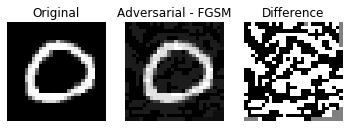

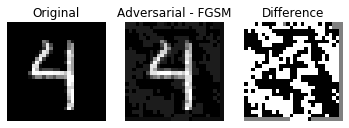

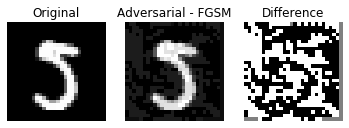

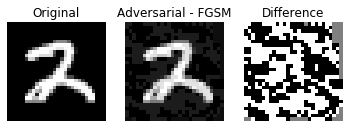

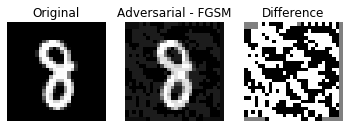

In [0]:
fgsm_vis_counter = 0
for (data, perturbed_data, target) in perturbed_dataset:
    if fgsm_vis_counter >= 5:
        break
    
    original_image = data[0].cpu().detach().numpy()
    original_image = original_image.reshape(original_image.shape[1], original_image.shape[2])
    adversarial_image = perturbed_data[0].cpu().detach().numpy()
    adversarial_image = adversarial_image.reshape(adversarial_image.shape[1], adversarial_image.shape[2])

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial - FGSM')
    plt.imshow(adversarial_image)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial_image - original_image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')
    fgsm_vis_counter += 1

plt.show()

# Attack 0 - FGSM

FGSM runs on range of epsilon values, one of which is chosen as the optimal value for the attack and defense evaluation.

In [0]:
fgsm_accuracies = []
fgsm_examples = []
original_perturbed_dataset = []
epsilons = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3]

for epsilon in epsilons:
    accuracy, example_set, original_perturbed_data = fgsm_test(test_loader, epsilon)
    fgsm_accuracies.append(accuracy)
    fgsm_examples.append(example_set)
    original_perturbed_dataset.append(original_perturbed_data)

C:\Users\agarw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 0.0	Test Accuracy = 9223 / 10000 = 92.23%
Epsilon: 0.05	Test Accuracy = 9090 / 10000 = 90.9%
Epsilon: 0.1	Test Accuracy = 8824 / 10000 = 88.24%
Epsilon: 0.15	Test Accuracy = 8563 / 10000 = 85.63%
Epsilon: 0.2	Test Accuracy = 8186 / 10000 = 81.86%
Epsilon: 0.3	Test Accuracy = 7249 / 10000 = 72.49%


The epsilon which resulted least accuracy is picked for further evaluation -  attack and defense.

In [0]:
chosen_epsilon = epsilons[np.argmin(np.asarray(fgsm_accuracies))]
chosen_accuracy, chosen_example_set, chosen_original_perturbed_dataset = fgsm_test(test_loader, chosen_epsilon)

C:\Users\agarw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 0.3	Test Accuracy = 7293 / 10000 = 72.92999999999999%


Visualization : Original - Adversarial Image - Difference Generated

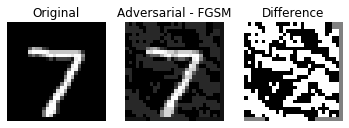

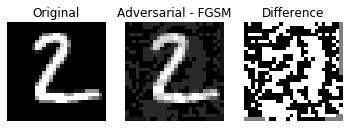

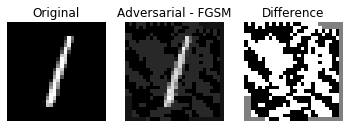

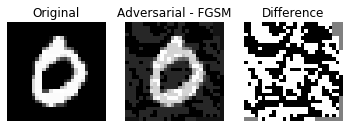

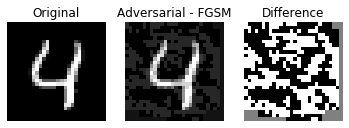

In [0]:
fgsm_vis_counter = 0
for (data, perturbed_data, target) in chosen_original_perturbed_dataset:
    if fgsm_vis_counter >= 5:
        break
    
    original_image = data[0].cpu().detach().numpy()
    original_image = original_image.reshape(original_image.shape[1], original_image.shape[2])
    adversarial_image = perturbed_data[0].cpu().detach().numpy()
    adversarial_image = adversarial_image.reshape(adversarial_image.shape[1], adversarial_image.shape[2])

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial - FGSM')
    plt.imshow(adversarial_image)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial_image - original_image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')
    fgsm_vis_counter += 1

plt.show()

### 1.1.3: Results


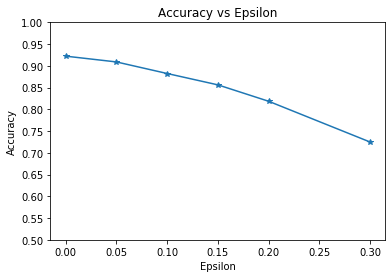

In [0]:
plt.plot(epsilons, fgsm_accuracies, "*-")
plt.yticks(np.arange(0.5, 1.01, step=0.05))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

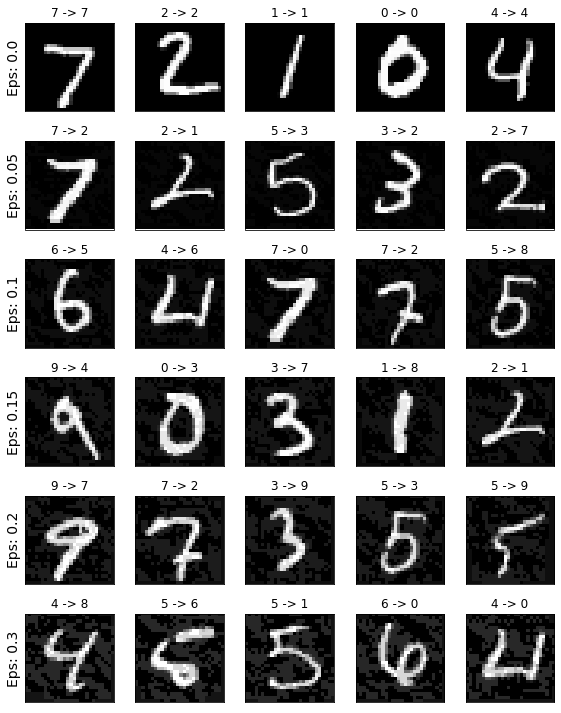

In [0]:
count = 0
plt.figure(figsize=(8,10))
for epsilon_index in range(len(epsilons)):
    for example_index in range(len(fgsm_examples[epsilon_index])):
        count += 1
        plt.subplot(len(epsilons),len(fgsm_examples[0]),count)
        plt.xticks([], [])
        plt.yticks([], [])
        if example_index == 0:
            plt.ylabel("Eps: {}".format(epsilons[epsilon_index]), fontsize=14)
        orig,adv,ex = fgsm_examples[epsilon_index][example_index]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### 1.2.1: Use of Foolbox libraries for other attacks


In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0],1, 28, 28)
x_test = x_test.reshape(x_test.shape[0],1, 28, 28)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
loadedNetwork = loadedNetwork.eval()
fmodel = foolbox.models.PyTorchModel(loadedNetwork, bounds=(0, 255), num_classes=10)
print("Mean Accuracy for Predictions on Original Data: {0:.2f}%".format(np.mean(fmodel.forward(x_test).argmax(axis=-1) == y_test) * 100))

C:\Users\agarw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Mean Accuracy for Predictions on Original Data: 93.23%


# Attack 1 - Adversarial Deformation (Adef)

In [0]:
# (a) attack 1
attack = foolbox.attacks.ADefAttack(fmodel)
adversarials_1 = attack(np.array(x_test), np.array(y_test))

print("Mean Accuracy for Predictions on Perturbed Data by ADefAttack: {0:.2f}%".format(np.mean(fmodel.forward(adversarials_1).argmax(axis=-1) == y_test) * 100))

C:\Users\agarw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\agarw\.conda\envs\cysecml\lib\site-packages\foolbox\attacks\adef_attack.py:159: RuntimeWarning: invalid value encountered in true_divide
  vec_field[:, :, 0] = -fval * alpha1 / norm_squared_alpha
C:\Users\agarw\.conda\envs\cysecml\lib\site-packages\foolbox\attacks\adef_attack.py:160: RuntimeWarning: invalid value encountered in true_divide
  vec_field[:, :, 1] = -fval * alpha2 / norm_squared_alpha
C:\Users\agarw\.conda\envs\cysecml\lib\site-packages\foolbox\attacks\base.py:95: UserWarning: ADefAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


Mean Accuracy for Predictions on Perturbed Data by ADefAttack: 5.32%


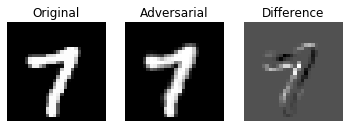

C:\Users\agarw\.conda\envs\cysecml\lib\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\agarw\.conda\envs\cysecml\lib\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\agarw\.conda\envs\cysecml\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\agarw\.conda\envs\cysecml\lib\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
C:\Users\agarw\.conda\envs\cysecml\lib\site-packages\numpy\ma\core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


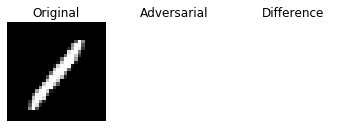

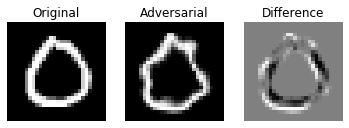

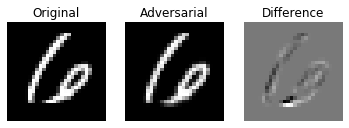

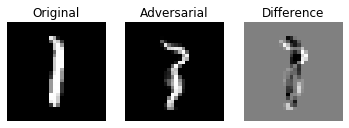

In [0]:
random_sample = random.sample(range(0, len(x_test)), 5)
for number in random_sample:
    image = x_test[number]
    image = image.transpose(1, 2, 0)
    image = image.reshape(image.shape[0], image.shape[1])
    adversarial = adversarials_1[number]
    adversarial = adversarial.transpose(1, 2, 0)
    adversarial = adversarial.reshape(adversarial.shape[0], adversarial.shape[1])

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial - image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

plt.show()

# Attack 2 - Decoupled Direction Norm for Gradient-based L2 Attack

In [0]:
# (b) attack 2

attack = foolbox.attacks.DecoupledDirectionNormL2Attack(fmodel)
adversarials_2 = attack(np.array(x_test), np.array(y_test))

print("Mean Accuracy for Predictions on Perturbed Data by Decoupled Direction - Gradient-based L2 Attack: {0:.2f}%".format(np.mean(fmodel.forward(adversarials_2).argmax(axis=-1) == y_test) * 100))

C:\Users\agarw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Mean Accuracy for Predictions on Perturbed Data by Decoupled Direction - Gradient-based L2 Attack: 0.00%


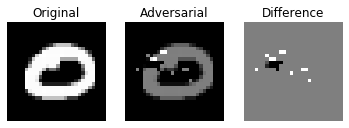

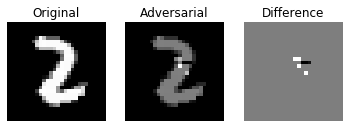

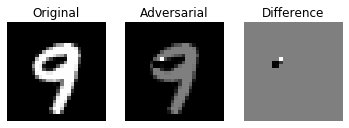

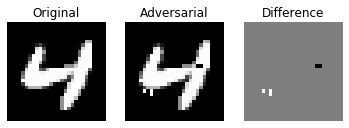

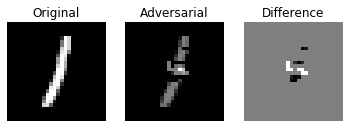

In [0]:
random_sample = random.sample(range(0, len(x_test)), 5)
for number in random_sample:
    image = x_test[number]
    image = image.transpose(1, 2, 0)
    image = image.reshape(image.shape[0], image.shape[1])
    adversarial = adversarials_2[number]
    adversarial = adversarial.transpose(1, 2, 0)
    adversarial = adversarial.reshape(adversarial.shape[0], adversarial.shape[1])

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial - image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

plt.show()

### 1.2.2: Results
Original Images - Attack 0 Images - Attack 1 Images - Attack 2 Images


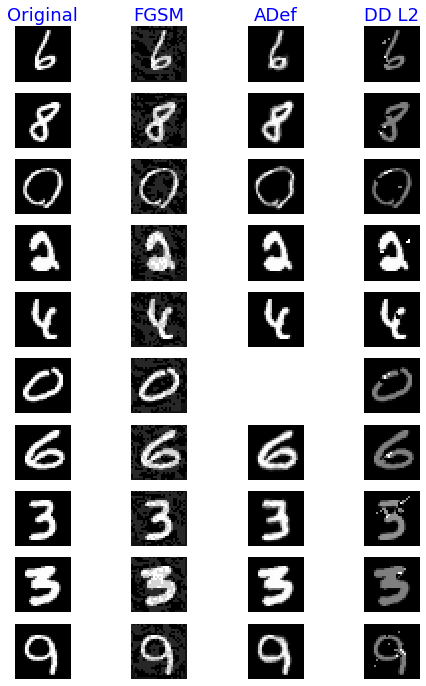

In [0]:
list_range = min(len(chosen_original_perturbed_dataset), len(adversarials_2), len(adversarials_2))
random_samples = random.sample(range(0, list_range), 10)

images_ori = []
fgsm_examples = []
adv_Method1 = []
adv_Method2 = []

for number in random_samples:
    images_ori.append(x_test[number][0])
    fgsm_examples.append(chosen_original_perturbed_dataset[number][1][0][0].cpu().detach().numpy())
    adv_Method1.append(adversarials_1[number][0])
    adv_Method2.append(adversarials_2[number][0])

# template code (Please feel free to change this)
# (each column corresponds to one attack method)
col_titles = ['Original','FGSM','ADef', 'DD L2'] 
nsamples = 10
nrows = nsamples
ncols = len(col_titles)

fig, axes = plt.subplots(nrows,ncols,figsize=(8,12))  # create the figure with subplots
[ax.set_axis_off() for ax in axes.ravel()]  # remove the axis

for ax, col in zip(axes[0], col_titles): # set up the title for each column
    ax.set_title(col,fontdict={'fontsize':18,'color':'b'})

for i in range(nsamples):
    axes[i,0].imshow(images_ori[i])
    axes[i,1].imshow(fgsm_examples[i])
    axes[i,2].imshow(adv_Method1[i])
    axes[i,3].imshow(adv_Method2[i])
                  

# Differences observed in different attacking methods

- There are clear distinctions between the disturbances created by each of the three attack methods implemented here because of their underlying adversarial generation methods. For instance, FGSM relies on the gradient of the datapoint to create changes each time the data is loaded and is not static. Adef randomly creates small perturbations in the image without relying on the gradient value of the image and thus, does it adaptively on the run. The last attack also relies on the gradient values but not necessarily to the specified epsilon values. It tries to optimize the disturbance such that even small differences lead to misclassification.

# Success of the attacks
- The attack does not always succeed for all the adversarial samples. It depends upon the amount of noise added to the original data i.e. with increasing value of epsilon, there is greater perturbation, which confuses the model to discriminate between classes and thus, result in false predictions, as desired. In this project, there is a considerable difference between the accuracy value when we epsilon value is 0.1 & 0.4 respectively.<br>

- It is observed that the Adversarial Deformation ADef attack takes the longest runtime, because it iteratively applies small deformations to the image which take a longer time to compute.
The runtime for Decoupled Directional Norm is reasonable and found to be in the midway range comparatively. Within a few iterations, it tries to successfully malforme the original data such that it is difficult for the classifier to yield correct output.
FGSM needs two backwards passes to compute gradients separately for the perturbation and the model weights. As a result, the computational complexity for an epoch of FGSM adversarial training is equivalent to two epochs of standard training. As such, it runs the fastest amongst our 3 chosen attacks.

- All the three implemented attacks are white-box attacks i.e. in all the three attacking techniques, the attack uses the underlying classifier model to generate the adversarial images over multiple iterations. 

# 2. Defense 


### 2.1: Implementing a defense


We reload the initially trained model on the original training dataset

In [0]:
loadedNetwork = Net().to(device)
loadedOptimizer = optim.SGD(loadedNetwork.parameters(), lr=learning_rate, momentum=momentum)

loadedNetwork.load_state_dict(torch.load("mode.pth"))
loadedOptimizer.load_state_dict(torch.load("optimizer.pth"))

In [0]:
loss_function = F.nll_loss
loadedNetwork.trainable = True
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
print(network)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(0,n_epochs)]
train_accuracy = []
test_accuracy = []

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


# Defense Implemented: Adversarial Training
Train the existing network on adversarial images generated from the training dataset images

In [0]:
def adversarial_train(epoch):
    correct = 0
    loadedNetwork.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        perturbed_data = data + fgsm_attack(data, target, chosen_epsilon)
        adversarial_output = loadedNetwork(perturbed_data)
        loss = loss_function(adversarial_output, target)
        #loss = (loss + adversarial_loss) / 2
            
        pred = adversarial_output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
        optimizer.zero_grad()     
        loss.backward(retain_graph=True)
        optimizer.step()
        
        torch.save(loadedNetwork.state_dict(), 'mode_adv_def.pth')
        torch.save(optimizer.state_dict(), 'optimizer_adv_def.pth')
    train_accuracy.append((100. * correct / len(train_loader.dataset)).cpu().detach().numpy())
    return train_accuracy

Then, we run the test on the model trained on adversarial images as well as original datapoints.

In [0]:
for epoch in range(0, 3):
    train_accuracy = adversarial_train(epoch)
    print("Training Accuracy: ", train_accuracy[epoch], "%")
    chosen_defense_accuracy, chosen_example_set, chosen_original_perturbed_dataset = fgsm_test(test_loader, 0.1)

C:\Users\agarw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Accuracy:  73.53834 %
Epsilon: 0.1	Test Accuracy = 8873 / 10000 = 88.73%
Training Accuracy:  73.496666 %
Epsilon: 0.1	Test Accuracy = 8865 / 10000 = 88.64999999999999%
Training Accuracy:  73.291664 %
Epsilon: 0.1	Test Accuracy = 8883 / 10000 = 88.83%


In [0]:
print('Accuracy on adversarial samples (FGSM) %.2f'%chosen_accuracy)
print('Accuracy on adversarial samples (FGSM) after defense %.2f'%chosen_defense_accuracy)

Accuracy on adversarial samples (FGSM) 0.73
Accuracy on adversarial samples (FGSM) after defense 0.89


## 2.2: Conclusions

### Choice of defense

We used adversarial training in this exercise to make our classifier also learn the adversarial version of the datapoints. This helps the network to accurately classify the test dataset with adversarial disturbances (fgsm_test) relatively better than without the defense.

Adversarial training is a fairly simple technique that works because the network is not also aware of the noisy datapoints which may come across during testing and tries to optimize accordingly. The model is retrained on the images that have been created by exploiting its own gradient descent values over pixel changes. These changes should ideally be captured by the model in the subsequent training process and thereby reduce the misclassification of further adversarial images generated on the test data.

### Other points to note

1) Choosing the value of epsilon in important in generating the adversarial data. It can be oberved that increasing the value of epsilon decreases the accuracy of classification, but this comes at the price of the adversarial images being perceptible even to the human eye based on the difference created.

2) There has been no mutual agreement over the research community on what the optimum value of epsilon should be. The ultimate choice of epsilon must depend on the model itself and the adversarial images that are generated by it. The value of epsilon is essentially the deviation of the generated image from the original image. 
